## Optimization 2 Project - Optimal Airline Booking Policy

In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

### Model Parameters

In [2]:
TIME_STEPS = 365
OVERBOOK_COACH = 5
N_SEATS_COACH_ORIGINAL = 100
N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH
N_SEATS_FIRST_CLASS = 20
SHOWUP_PROB_COACH = 0.95
SHOWUP_PROB_FIRST_CLASS = 0.97
PRICE_COACH = [300, 350]
PRICE_FIRST_CLASS = [425, 500]
COACH_PRICE_INCREASE_IF_FC_SOLD_OUT = 0.03
PROB_COACH = [0.65, 0.30]
PROB_FIRST_CLASS = [0.08, 0.04]
COST_UPGRADE = 50
COST_OFF = 425
DISCOUNT = 1/(1+0.17/365)

# Assumption 1: Allowing for five seats to be overbooked

In [3]:
t_values = range(TIME_STEPS+1)
c_values = range(N_SEATS_COACH+1)
f_values = range(N_SEATS_FIRST_CLASS+1)

V = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))
U = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))

In [4]:
# Terminal condition
for c in c_values:
    for f in f_values:
        exp_cost = 0
        for i in range(N_SEATS_COACH-OVERBOOK_COACH+1, c+1):
            for j in range(f+1): # i = 104, j =  18
                coach_extra_show = max(i-(N_SEATS_COACH-OVERBOOK_COACH), 0) # 4
                first_class_remaining_seats = N_SEATS_FIRST_CLASS - j # 2
                n_upgrades = min(first_class_remaining_seats, coach_extra_show) # 4
                cost = n_upgrades * COST_UPGRADE + (coach_extra_show - n_upgrades) * COST_OFF
                prob = binom.pmf(i, c, SHOWUP_PROB_COACH) * binom.pmf(j, f, SHOWUP_PROB_FIRST_CLASS)
                exp_cost += cost * prob
        V[len(t_values)-1, c, f] = -exp_cost
        U[len(t_values)-1, c, f] = -1 # meaning nothing

In [5]:
for t in reversed(range(TIME_STEPS)):
    for c_seats in range(N_SEATS_COACH+1):
        for f_seats in range(N_SEATS_FIRST_CLASS+1):
            profit_today = []
            for c in range(2):  # 0 is low price, 1 is high price for coach
                for f in range(2):  # 0 is low price, 1 is high price for first class
                    expected_profit = 0
                    for sc in range(2):  # coach sale (0 or 1)
                        for sf in range(2):  # first-class sale (0 or 1)
                            prob_c = PROB_COACH[c]
                            prob_f = PROB_FIRST_CLASS[f]

                            if f_seats == N_SEATS_FIRST_CLASS:
                                prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
                                prob_f = 0
                            if c_seats == N_SEATS_COACH:
                                prob_c = 0

                            pc = prob_c if sc else 1 - prob_c
                            pf = prob_f if sf else 1 - prob_f
                            prob = pc * pf

                            next_c = min(c_seats + sc, N_SEATS_COACH)
                            next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                            reward = sc * PRICE_COACH[c] + sf * PRICE_FIRST_CLASS[f]
                            future_val = V[t + 1, next_c, next_f]

                            expected_profit += prob * (reward + DISCOUNT * future_val)

                    profit_today.append(expected_profit)
            V[t, c_seats, f_seats] = max(profit_today)
            U[t, c_seats, f_seats] = np.argmax(profit_today)


In [6]:
V[0, 0, 0]

41886.158624195894

#### Modular function -- to be used and modified in further iterations of model.

In [7]:
def policy(max_overbooked_seats, has_option_to_not_sell, apply_seasonality):
    OVERBOOK_COACH = max_overbooked_seats
    N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH

    t_values = range(TIME_STEPS+1)
    c_values = range(N_SEATS_COACH+1)
    f_values = range(N_SEATS_FIRST_CLASS+1)

    V = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))
    U = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))

    # Terminal condition
    for c in c_values:
        for f in f_values:
            exp_cost = 0
            for i in range(N_SEATS_COACH-OVERBOOK_COACH+1, c+1):
                for j in range(f+1): # i = 104, j =  18
                    coach_extra_show = max(i-(N_SEATS_COACH-OVERBOOK_COACH), 0) # 4
                    first_class_remaining_seats = N_SEATS_FIRST_CLASS - j # 2
                    n_upgrades = min(first_class_remaining_seats, coach_extra_show) # 4
                    cost = n_upgrades * COST_UPGRADE + (coach_extra_show - n_upgrades) * COST_OFF
                    prob = binom.pmf(i, c, SHOWUP_PROB_COACH) * binom.pmf(j, f, SHOWUP_PROB_FIRST_CLASS)
                    exp_cost += cost * prob
            V[len(t_values)-1, c, f] = -exp_cost
            U[len(t_values)-1, c, f] = -1 # meaning nothing

    for t in reversed(range(TIME_STEPS)):
        for c_seats in range(N_SEATS_COACH+1):
            for f_seats in range(N_SEATS_FIRST_CLASS+1):
                profit_today = []
                for c in range(2):  # 0 is low price, 1 is high price for coach
                    for f in range(2):  # 0 is low price, 1 is high price for first class
                        expected_profit = 0
                        for sc in range(2):  # coach sale (0 or 1)
                            for sf in range(2):  # first-class sale (0 or 1)
                                prob_c = PROB_COACH[c]
                                prob_f = PROB_FIRST_CLASS[f]

                                if f_seats == N_SEATS_FIRST_CLASS:
                                    prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
                                    prob_f = 0
                                if c_seats == N_SEATS_COACH:
                                    prob_c = 0

                                pc = prob_c if sc else 1 - prob_c
                                pf = prob_f if sf else 1 - prob_f
                                prob = pc * pf

                                next_c = min(c_seats + sc, N_SEATS_COACH)
                                next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                                reward = sc * PRICE_COACH[c] + sf * PRICE_FIRST_CLASS[f]
                                future_val = V[t + 1, next_c, next_f]

                                expected_profit += prob * (reward + DISCOUNT * future_val)

                        profit_today.append(expected_profit)
                V[t, c_seats, f_seats] = max(profit_today)
                U[t, c_seats, f_seats] = np.argmax(profit_today)

    return V, U

In [8]:
V, U = policy(max_overbooked_seats=5, has_option_to_not_sell=False, apply_seasonality=False)
V[0][0][0]

41886.158624195894

#### Assumption 1 Iterations: Find Optimal Overbooking Number w.r.t Expected Profit

In [9]:
V_dict = {}
for OVERBOOK_COACH in range(6, 16):
    V, U = policy(max_overbooked_seats=OVERBOOK_COACH, has_option_to_not_sell=False, apply_seasonality=False)
    V_dict[OVERBOOK_COACH] = V[0, 0, 0]
V_dict

{6: 42011.221060444565,
 7: 42085.536155828784,
 8: 42122.1672687631,
 9: 42134.62483034168,
 10: 42132.90038235114,
 11: 42123.66593558076,
 12: 42111.02967047865,
 13: 42097.41950987738,
 14: 42084.1115703531,
 15: 42071.74230930798}

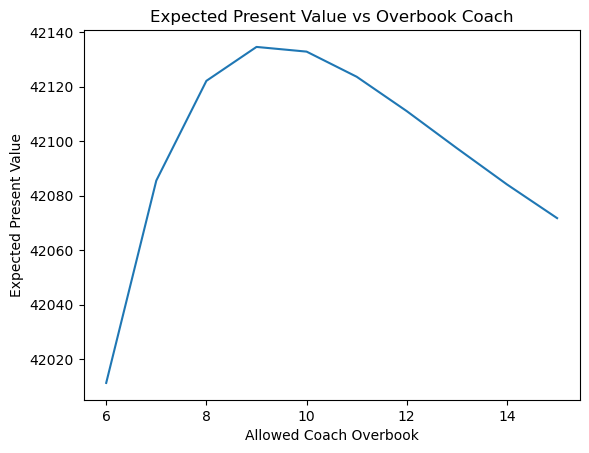

In [10]:
# plot V_dict
plt.plot(list(V_dict.keys()), list(V_dict.values()))
plt.xlabel('Allowed Coach Overbook')
plt.ylabel('Expected Present Value')
plt.title('Expected Present Value vs Overbook Coach')
plt.show()

### Assumption 2: "No-Sell" Option in Coach.

#### Modified function to account for "No-Sell" Option.

In [11]:
def policy(max_overbooked_seats, has_option_to_not_sell, apply_seasonality):
    OVERBOOK_COACH = max_overbooked_seats
    N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH

    t_values = range(TIME_STEPS+1)
    c_values = range(N_SEATS_COACH+1)
    f_values = range(N_SEATS_FIRST_CLASS+1)

    V = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))
    U = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))

    # Terminal condition
    for c in c_values:
        for f in f_values:
            exp_cost = 0
            for i in range(N_SEATS_COACH-OVERBOOK_COACH+1, c+1):
                for j in range(f+1): # i = 104, j =  18
                    coach_extra_show = max(i-(N_SEATS_COACH-OVERBOOK_COACH), 0) # 4
                    first_class_remaining_seats = N_SEATS_FIRST_CLASS - j # 2
                    n_upgrades = min(first_class_remaining_seats, coach_extra_show) # 4
                    cost = n_upgrades * COST_UPGRADE + (coach_extra_show - n_upgrades) * COST_OFF
                    prob = binom.pmf(i, c, SHOWUP_PROB_COACH) * binom.pmf(j, f, SHOWUP_PROB_FIRST_CLASS)
                    exp_cost += cost * prob
            V[len(t_values)-1, c, f] = -exp_cost
            U[len(t_values)-1, c, f] = -1 # meaning nothing

    for t in reversed(range(TIME_STEPS)):
        for c_seats in range(N_SEATS_COACH+1):
            for f_seats in range(N_SEATS_FIRST_CLASS+1):
                profit_today = []
                for c in range(2):  # 0 is low price, 1 is high price for coach
                    for f in range(2):  # 0 is low price, 1 is high price for first class
                        expected_profit = 0
                        for sc in range(2):  # coach sale (0 or 1)
                            for sf in range(2):  # first-class sale (0 or 1)
                                prob_c = PROB_COACH[c]
                                prob_f = PROB_FIRST_CLASS[f]

                                if f_seats == N_SEATS_FIRST_CLASS:
                                    prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
                                    prob_f = 0
                                if c_seats == N_SEATS_COACH:
                                    prob_c = 0

                                pc = prob_c if sc else 1 - prob_c
                                pf = prob_f if sf else 1 - prob_f
                                prob = pc * pf

                                next_c = min(c_seats + sc, N_SEATS_COACH)
                                next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                                reward = sc * PRICE_COACH[c] + sf * PRICE_FIRST_CLASS[f]
                                future_val = V[t + 1, next_c, next_f]

                                expected_profit += prob * (reward + DISCOUNT * future_val)

                        profit_today.append(expected_profit)

                if has_option_to_not_sell:
                    # add choice to not sell coach
                    for f in range(2):  # 0 is low price, 1 is high price for first class
                        expected_profit = 0
                        for sf in range(2):
                            prob_f = PROB_FIRST_CLASS[f]

                            if f_seats == N_SEATS_FIRST_CLASS:
                                prob_f = 0

                            pf = prob_f if sf else 1 - prob_f
                            prob = pf

                            next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                            reward = sf * PRICE_FIRST_CLASS[f]
                            future_val = V[t + 1, c_seats, next_f]

                            expected_profit += prob * (reward + DISCOUNT * future_val)
                        profit_today.append(expected_profit)
                V[t, c_seats, f_seats] = max(profit_today)
                U[t, c_seats, f_seats] = np.argmax(profit_today)

    return V, U

In [12]:
V, U = policy(max_overbooked_seats=20, has_option_to_not_sell=True, apply_seasonality=False)
V[0][0][0]

42139.892762319774

#### Assumption 2 Iterations: Find Optimal Overbooking Number w.r.t Expected Profit

In [13]:
V_dict = {}
for max_overbooked_seats in range(6, 21):
    V, U = policy(max_overbooked_seats=max_overbooked_seats, has_option_to_not_sell=True, apply_seasonality=False)
    V_dict[max_overbooked_seats] = V[0, 0, 0]
V_dict

{6: 42011.221060444565,
 7: 42085.536155828784,
 8: 42122.1672687631,
 9: 42134.62483034168,
 10: 42138.1404979132,
 11: 42139.32793981839,
 12: 42139.70894506631,
 13: 42139.83142494604,
 14: 42139.872224934035,
 15: 42139.88608106458,
 16: 42139.89071111938,
 17: 42139.89218324264,
 18: 42139.89261726655,
 19: 42139.89273402461,
 20: 42139.892762319774}

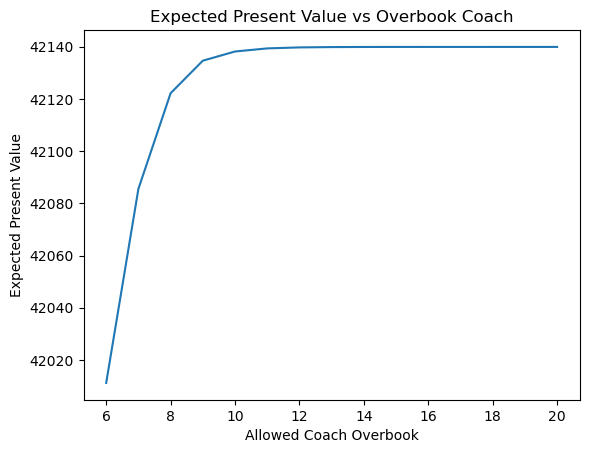

In [14]:
# plot V_dict
plt.plot(list(V_dict.keys()), list(V_dict.values()))
plt.xlabel('Allowed Coach Overbook')
plt.ylabel('Expected Present Value')
plt.title('Expected Present Value vs Overbook Coach')
plt.show()

### Assumption 3: Seasonality

Add seasonality to the function

In [15]:
def policy(max_overbooked_seats, has_option_to_not_sell, apply_seasonality):
    OVERBOOK_COACH = max_overbooked_seats
    N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH

    t_values = range(TIME_STEPS+1)
    c_values = range(N_SEATS_COACH+1)
    f_values = range(N_SEATS_FIRST_CLASS+1)

    V = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))
    U = np.zeros((TIME_STEPS+1, N_SEATS_COACH+1, N_SEATS_FIRST_CLASS+1))

    # Terminal condition
    for c in c_values:
        for f in f_values:
            exp_cost = 0
            for i in range(N_SEATS_COACH-OVERBOOK_COACH+1, c+1):
                for j in range(f+1): # i = 104, j =  18
                    coach_extra_show = max(i-(N_SEATS_COACH-OVERBOOK_COACH), 0) # 4
                    first_class_remaining_seats = N_SEATS_FIRST_CLASS - j # 2
                    n_upgrades = min(first_class_remaining_seats, coach_extra_show) # 4
                    cost = n_upgrades * COST_UPGRADE + (coach_extra_show - n_upgrades) * COST_OFF
                    prob = binom.pmf(i, c, SHOWUP_PROB_COACH) * binom.pmf(j, f, SHOWUP_PROB_FIRST_CLASS)
                    exp_cost += cost * prob
            V[len(t_values)-1, c, f] = -exp_cost
            U[len(t_values)-1, c, f] = -1 # meaning nothing

    for t in reversed(range(TIME_STEPS)):
        for c_seats in range(N_SEATS_COACH+1):
            for f_seats in range(N_SEATS_FIRST_CLASS+1):
                profit_today = []
                for c in range(2):  # 0 is low price, 1 is high price for coach
                    for f in range(2):  # 0 is low price, 1 is high price for first class
                        expected_profit = 0
                        for sc in range(2):  # coach sale (0 or 1)
                            for sf in range(2):  # first-class sale (0 or 1)
                                prob_c = PROB_COACH[c]
                                prob_f = PROB_FIRST_CLASS[f]

                                if apply_seasonality:
                                    prob_c *= (0.75 + t/730)
                                    prob_f *= (0.75 + t/730)
                                    
                                if f_seats == N_SEATS_FIRST_CLASS:
                                    prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
                                    prob_f = 0
                                if c_seats == N_SEATS_COACH:
                                    prob_c = 0


                                pc = prob_c if sc else 1 - prob_c
                                pf = prob_f if sf else 1 - prob_f
                                prob = pc * pf

                                next_c = min(c_seats + sc, N_SEATS_COACH)
                                next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                                reward = sc * PRICE_COACH[c] + sf * PRICE_FIRST_CLASS[f]
                                future_val = V[t + 1, next_c, next_f]

                                expected_profit += prob * (reward + DISCOUNT * future_val)

                        profit_today.append(expected_profit)

                if has_option_to_not_sell:
                    # add choice to not sell coach
                    for f in range(2):  # 0 is low price, 1 is high price for first class
                        expected_profit = 0
                        for sf in range(2):
                            prob_f = PROB_FIRST_CLASS[f]

                            if f_seats == N_SEATS_FIRST_CLASS:
                                prob_f = 0
                            if apply_seasonality:
                                prob_f *= (0.75 + t/730)
                            pf = prob_f if sf else 1 - prob_f
                            prob = pf

                            next_f = min(f_seats + sf, N_SEATS_FIRST_CLASS)
                            reward = sf * PRICE_FIRST_CLASS[f]
                            future_val = V[t + 1, c_seats, next_f]

                            expected_profit += prob * (reward + DISCOUNT * future_val)
                        profit_today.append(expected_profit)
                V[t, c_seats, f_seats] = max(profit_today)
                U[t, c_seats, f_seats] = np.argmax(profit_today)

    return V, U

#### Assumption 3: Scenario A - No "No-Sell" Option with Seasonality

In [16]:
V, U = policy(max_overbooked_seats=20, has_option_to_not_sell=False, apply_seasonality=True)
V[0][0][0]

41718.65026398372

#### Assumption 3: Scenario A - Iterations

In [17]:
V_dict = {}
for OVERBOOK_COACH in range(6, 21):
    V, U = policy(max_overbooked_seats=OVERBOOK_COACH, has_option_to_not_sell=False, apply_seasonality=True)
    V_dict[OVERBOOK_COACH] = V[0, 0, 0]
V_dict

{6: 41700.380646378944,
 7: 41772.902540447976,
 8: 41808.64931848447,
 9: 41820.96554591983,
 10: 41819.44509313984,
 11: 41810.56132600895,
 12: 41798.31879364694,
 13: 41785.10659442301,
 14: 41772.186888133525,
 15: 41760.18778686188,
 16: 41749.382887514534,
 17: 41739.86203716274,
 18: 41731.61598526032,
 19: 41724.57803339512,
 20: 41718.65026398372}

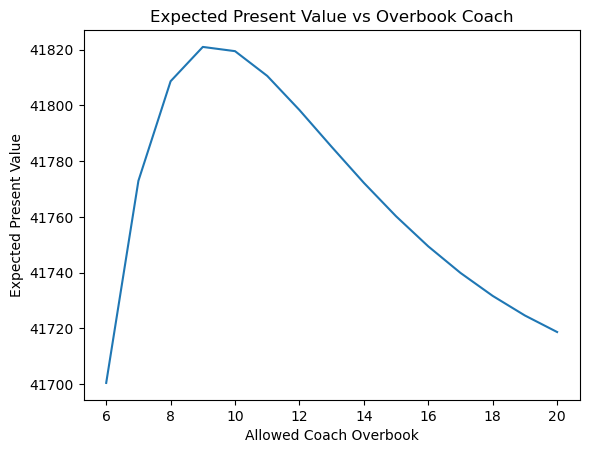

In [18]:
# plot V_dict
plt.plot(list(V_dict.keys()), list(V_dict.values()))
plt.xlabel('Allowed Coach Overbook')
plt.ylabel('Expected Present Value')
plt.title('Expected Present Value vs Overbook Coach')
plt.show()

#### Assumption 3: Scenario B - "No-Sell" Option with Seasonality

In [19]:
V, U = policy(max_overbooked_seats=20, has_option_to_not_sell=True, apply_seasonality=True)
V[0][0][0]

41826.44687221107

#### Assumption 3: Scenario B - Iterations

In [20]:
V_dict = {}
for OVERBOOK_COACH in range(6, 21):
    V, U = policy(max_overbooked_seats=OVERBOOK_COACH, has_option_to_not_sell=True, apply_seasonality=True)
    V_dict[OVERBOOK_COACH] = V[0, 0, 0]
V_dict

{6: 41700.380646378944,
 7: 41772.902540447976,
 8: 41808.64931848447,
 9: 41820.96554591983,
 10: 41824.610465613485,
 11: 41825.85938074218,
 12: 41826.26014488944,
 13: 41826.38632814655,
 14: 41826.4271038499,
 15: 41826.440577235306,
 16: 41826.44497570719,
 17: 41826.446345392884,
 18: 41826.44674217993,
 19: 41826.446847244115,
 20: 41826.44687221107}

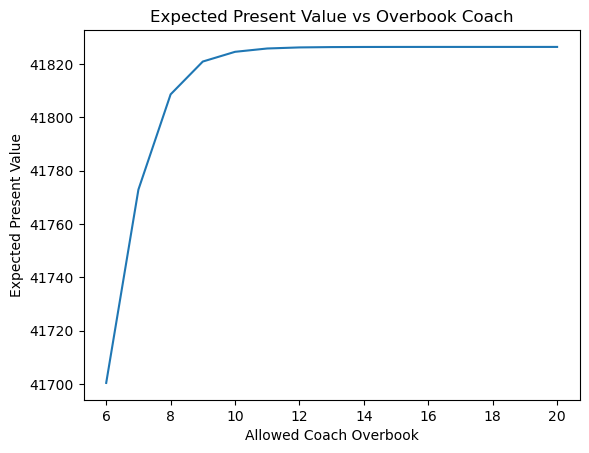

In [21]:
# plot V_dict
plt.plot(list(V_dict.keys()), list(V_dict.values()))
plt.xlabel('Allowed Coach Overbook')
plt.ylabel('Expected Present Value')
plt.title('Expected Present Value vs Overbook Coach')
plt.show()

### Optimal Policy Simulations

#### Scenario A: Maximum overbooked seats allowed to be nine, without the option to not sell tickets in coach, and seasonality incorporated.

Nine was chosen based on the above iterations. Expected profits seem to spike, with the returns diminishing after the number of overbooked seats is increased to ten.

Dynamic programming value: 41,820.97
--------------------------------------------------
Expected profit: 41,671.58
Standard deviation of profit: 990.21
--------------------------------------------------
Percentage of overbooked flights: 81.34%
Percentage of flights with at least one passenger kicked: 69.07%
Average overbooking costs: 1,186.65
Standard deviation of overbooking costs: 804.24
--------------------------------------------------
Coach price 'Low' used 4.42% of the time
Coach price 'High' used 95.58% of the time
'No-sell coach' chosen in 0.00% of decisions
First-class was full and blocked upgrades on 31.83% of flights


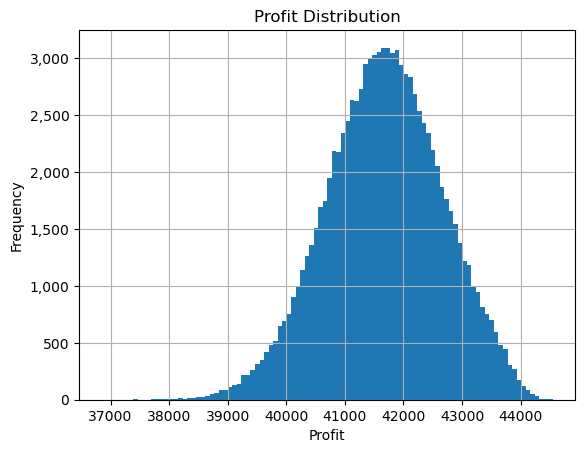

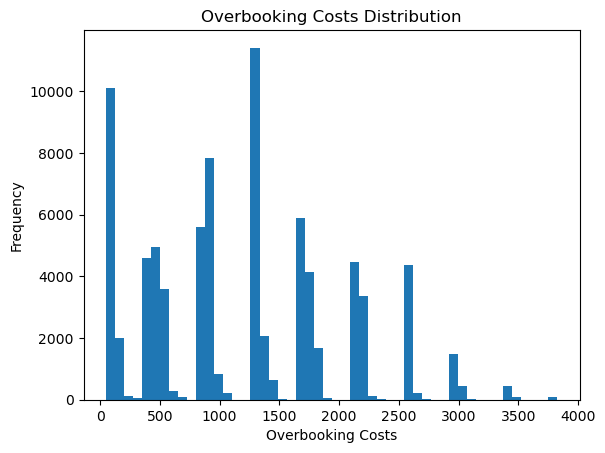

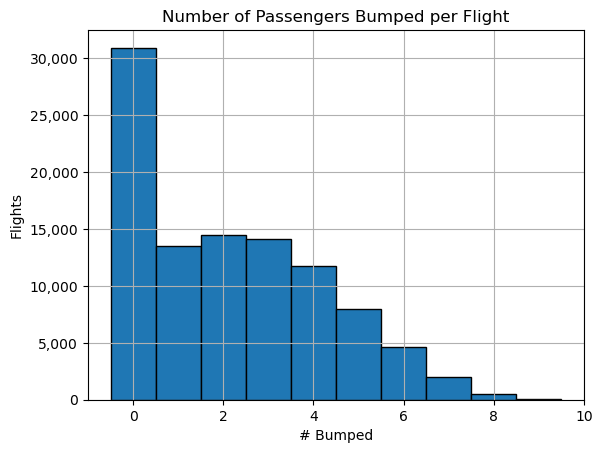

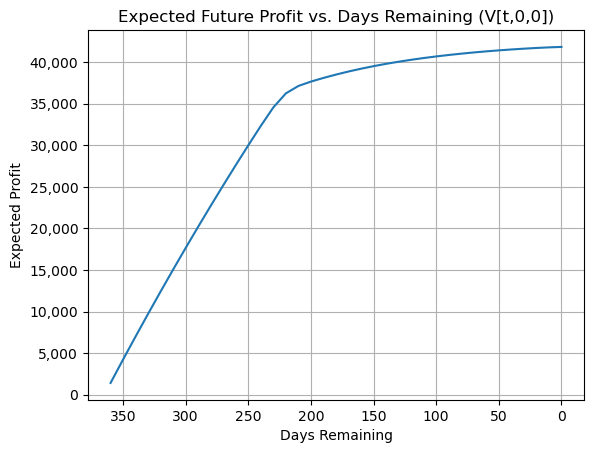

In [22]:
# policy simulation and analysis for overbooking problem

# run policy to get value and policy matrices
V, U = policy(max_overbooked_seats=9, has_option_to_not_sell=False, apply_seasonality=True)
print(f"Dynamic programming value: {V[0, 0, 0]:,.2f}")
print('-'*50)

# set parameters
max_overbooked_seats = 9
has_option_to_not_sell = False
apply_seasonality = True

OVERBOOK_COACH = max_overbooked_seats
N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH

actions = {-1:(None, None), 0:(0, 0), 1:(0, 1), 2:(1, 0), 3:(1, 1), 4:(None, 0), 5:(None, 1)}

n_sim = 100_000

# initialize tracking lists and counters
profit_lst = []
bumped_passengers = []
blocked_upgrades = []
coach_price_decisions = []
overbooking_costs = []

overbook_count = 0
kick_count = 0
no_sell_count = 0

# run simulation
for _ in range(n_sim):
    c_sold, f_sold = 0, 0
    profit = 0

    for t in range(TIME_STEPS):
        action_idx = U[t][c_sold][f_sold]
        action = actions[action_idx]

        prob_c = PROB_COACH[action[0]] if action[0] is not None else 0
        prob_f = PROB_FIRST_CLASS[action[1]] if action[1] is not None else 0

        if apply_seasonality:
            factor = 0.75 + t / 730
            prob_c *= factor
            prob_f *= factor
        if f_sold == N_SEATS_FIRST_CLASS:
            if action[0] is not None:
                prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
            prob_f = 0
        if c_sold == N_SEATS_COACH:
            prob_c = 0


        # simulate sale
        c = np.random.random() < prob_c
        f = np.random.random() < prob_f

        c_sold += c
        f_sold += f

        if action[0] is not None:
            coach_price_decisions.append(action[0])
        else:
            no_sell_count += 1

        if action[0] is not None:
            profit += (DISCOUNT**t) * (c * PRICE_COACH[action[0]])
        if action[1] is not None:
            profit += (DISCOUNT**t) * (f * PRICE_FIRST_CLASS[action[1]])

    # simulate arrivals on flight day
    c_show = np.sum(np.random.random(size=c_sold) < SHOWUP_PROB_COACH)
    f_show = np.sum(np.random.random(size=f_sold) < SHOWUP_PROB_FIRST_CLASS)

    if c_show > N_SEATS_COACH - OVERBOOK_COACH:
        overbook_count += 1
        coach_extra_show = max(c_show - (N_SEATS_COACH - OVERBOOK_COACH), 0)
        first_class_remaining_seats = N_SEATS_FIRST_CLASS - f_show
        n_upgrades = min(first_class_remaining_seats, coach_extra_show)
        bumped = coach_extra_show - n_upgrades
        cost = n_upgrades * COST_UPGRADE + bumped * COST_OFF

        if bumped > 0:
            kick_count += 1

        bumped_passengers.append(bumped)
        blocked_upgrades.append(first_class_remaining_seats == 0 and coach_extra_show > 0)
        overbooking_costs.append(cost)
        profit -= cost
    else:
        bumped_passengers.append(0)
        blocked_upgrades.append(False)

    profit_lst.append(profit)

# print performance summary
print(f'Expected profit: {np.mean(profit_lst):,.2f}')
print(f'Standard deviation of profit: {np.std(profit_lst):,.2f}')
print('-'*50)
print(f'Percentage of overbooked flights: {overbook_count / n_sim * 100:.2f}%')
print(f'Percentage of flights with at least one passenger kicked: {kick_count / n_sim * 100:.2f}%')
print(f'Average overbooking costs: {np.mean(overbooking_costs):,.2f}')
print(f'Standard deviation of overbooking costs: {np.std(overbooking_costs):,.2f}')
print('-'*50)

# breakdown of pricing decisions
counts = Counter(coach_price_decisions)
total_actions = sum(counts.values())
for k in sorted(counts):
    label = "Low" if k == 0 else "High"
    print(f"Coach price '{label}' used {counts[k]/total_actions*100:.2f}% of the time")

# how often no-sell was chosen
print(f"'No-sell coach' chosen in {no_sell_count / (TIME_STEPS * n_sim) * 100:.2f}% of decisions")

# how often upgrades were blocked
blocked_rate = np.mean(blocked_upgrades)
print(f"First-class was full and blocked upgrades on {blocked_rate*100:.2f}% of flights")

# plots

# profit distribution
plt.hist(profit_lst, bins=100)
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# overbooking costs
plt.hist(overbooking_costs, bins=50)
plt.xlabel('Overbooking Costs')
plt.ylabel('Frequency')
plt.title('Overbooking Costs Distribution')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# bumped passengers distribution
plt.hist(bumped_passengers, bins=range(0, max(bumped_passengers)+2), edgecolor='black', align='left')
plt.title("Number of Passengers Bumped per Flight")
plt.xlabel("# Bumped")
plt.ylabel("Flights")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# expected future profit vs days remaining
days = range(0, TIME_STEPS + 1, 10)
values = [V[t, 0, 0] for t in days]
plt.plot(days, values)
plt.title("Expected Future Profit vs. Days Remaining (V[t,0,0])")
plt.xlabel("Days Remaining")
plt.ylabel("Expected Profit")
plt.gca().invert_xaxis()
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()


#### Scenario B: Maximum overbooked seats allowed to be twelve, with the option to not sell tickets in coach, and seasonality incorporated.

Twelve was chosen based on the above iterations. Expected profits seem to pleatau after twelve, with no-real benifit from overbooking more seats. Trade-off between marginal profits and customer satisfaction. Less overbooking is probably the best option here.

Dynamic programming value: 41,826.26
--------------------------------------------------
Expected profit: 41,668.17
Standard deviation of profit: 999.81
--------------------------------------------------
Percentage of overbooked flights: 82.37%
Percentage of flights with at least one passenger kicked: 70.75%
Average overbooking costs: 1,218.27
Standard deviation of overbooking costs: 811.44
--------------------------------------------------
Coach price 'Low' used 1.55% of the time
Coach price 'High' used 98.45% of the time
'No-sell coach' chosen in 2.80% of decisions
First-class was full and blocked upgrades on 30.55% of flights


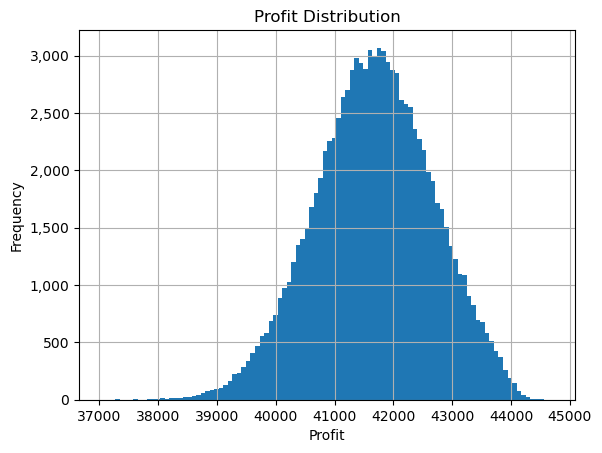

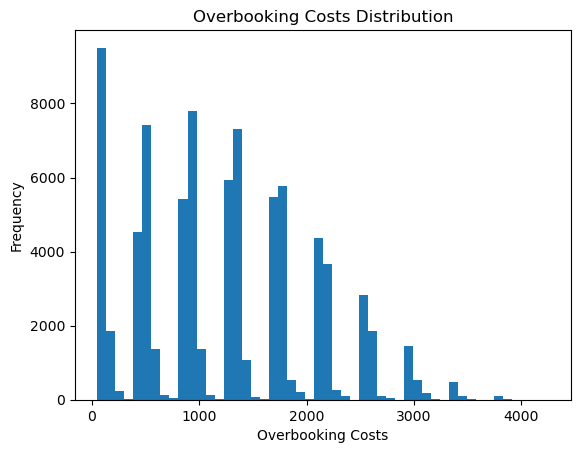

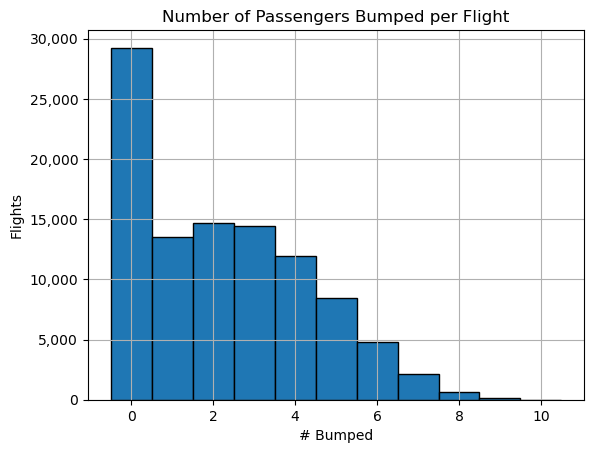

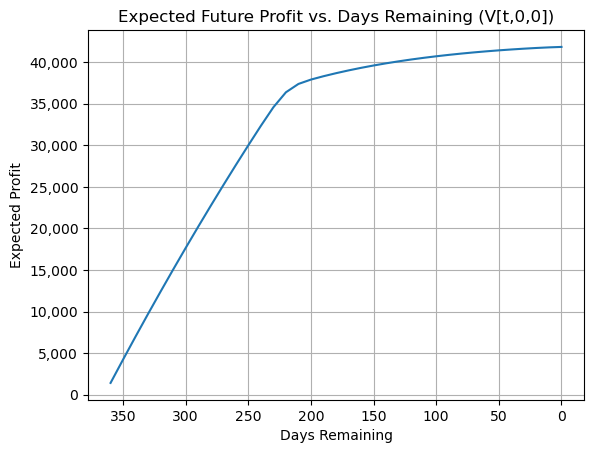

In [23]:
# policy simulation and analysis for overbooking problem

# run policy to get value and policy matrices
V, U = policy(max_overbooked_seats=12, has_option_to_not_sell=True, apply_seasonality=True)
print(f"Dynamic programming value: {V[0, 0, 0]:,.2f}")
print('-'*50)

# set parameters
max_overbooked_seats = 12
has_option_to_not_sell = True
apply_seasonality = True

OVERBOOK_COACH = max_overbooked_seats
N_SEATS_COACH = N_SEATS_COACH_ORIGINAL + OVERBOOK_COACH

actions = {-1:(None, None), 0:(0, 0), 1:(0, 1), 2:(1, 0), 3:(1, 1), 4:(None, 0), 5:(None, 1)}

n_sim = 100_000

# initialize tracking lists and counters
profit_lst = []
bumped_passengers = []
blocked_upgrades = []
coach_price_decisions = []
overbooking_costs = []

overbook_count = 0
kick_count = 0
no_sell_count = 0

# run simulation
for _ in range(n_sim):
    c_sold, f_sold = 0, 0
    profit = 0

    for t in range(TIME_STEPS):
        action_idx = U[t][c_sold][f_sold]
        action = actions[action_idx]

        prob_c = PROB_COACH[action[0]] if action[0] is not None else 0
        prob_f = PROB_FIRST_CLASS[action[1]] if action[1] is not None else 0
        if apply_seasonality:
            factor = 0.75 + t / 730
            prob_c *= factor
            prob_f *= factor
        if f_sold == N_SEATS_FIRST_CLASS:
            if action[0] is not None:
                prob_c += COACH_PRICE_INCREASE_IF_FC_SOLD_OUT
            prob_f = 0
        if c_sold == N_SEATS_COACH:
            prob_c = 0

        

        # simulate sale
        c = np.random.random() < prob_c
        f = np.random.random() < prob_f

        c_sold += c
        f_sold += f

        if action[0] is not None:
            coach_price_decisions.append(action[0])
        else:
            no_sell_count += 1

        if action[0] is not None:
            profit += (DISCOUNT**t) * (c * PRICE_COACH[action[0]])
        if action[1] is not None:
            profit += (DISCOUNT**t) * (f * PRICE_FIRST_CLASS[action[1]])

    # simulate arrivals on flight day
    c_show = np.sum(np.random.random(size=c_sold) < SHOWUP_PROB_COACH)
    f_show = np.sum(np.random.random(size=f_sold) < SHOWUP_PROB_FIRST_CLASS)

    if c_show > N_SEATS_COACH - OVERBOOK_COACH:
        overbook_count += 1
        coach_extra_show = max(c_show - (N_SEATS_COACH - OVERBOOK_COACH), 0)
        first_class_remaining_seats = N_SEATS_FIRST_CLASS - f_show
        n_upgrades = min(first_class_remaining_seats, coach_extra_show)
        bumped = coach_extra_show - n_upgrades
        cost = n_upgrades * COST_UPGRADE + bumped * COST_OFF

        if bumped > 0:
            kick_count += 1

        bumped_passengers.append(bumped)
        blocked_upgrades.append(first_class_remaining_seats == 0 and coach_extra_show > 0)
        overbooking_costs.append(cost)
        profit -= cost
    else:
        bumped_passengers.append(0)
        blocked_upgrades.append(False)

    profit_lst.append(profit)

# print performance summary
print(f'Expected profit: {np.mean(profit_lst):,.2f}')
print(f'Standard deviation of profit: {np.std(profit_lst):,.2f}')
print('-'*50)
print(f'Percentage of overbooked flights: {overbook_count / n_sim * 100:.2f}%')
print(f'Percentage of flights with at least one passenger kicked: {kick_count / n_sim * 100:.2f}%')
print(f'Average overbooking costs: {np.mean(overbooking_costs):,.2f}')
print(f'Standard deviation of overbooking costs: {np.std(overbooking_costs):,.2f}')
print('-'*50)

# breakdown of pricing decisions
counts = Counter(coach_price_decisions)
total_actions = sum(counts.values())
for k in sorted(counts):
    label = "Low" if k == 0 else "High"
    print(f"Coach price '{label}' used {counts[k]/total_actions*100:.2f}% of the time")

# how often no-sell was chosen
print(f"'No-sell coach' chosen in {no_sell_count / (TIME_STEPS * n_sim) * 100:.2f}% of decisions")

# how often upgrades were blocked
blocked_rate = np.mean(blocked_upgrades)
print(f"First-class was full and blocked upgrades on {blocked_rate*100:.2f}% of flights")

# plots

# profit distribution
plt.hist(profit_lst, bins=100)
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# overbooking costs
plt.hist(overbooking_costs, bins=50)
plt.xlabel('Overbooking Costs')
plt.ylabel('Frequency')
plt.title('Overbooking Costs Distribution')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# bumped passengers distribution
plt.hist(bumped_passengers, bins=range(0, max(bumped_passengers)+2), edgecolor='black', align='left')
plt.title("Number of Passengers Bumped per Flight")
plt.xlabel("# Bumped")
plt.ylabel("Flights")
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()

# expected future profit vs days remaining
days = range(0, TIME_STEPS + 1, 10)
values = [V[t, 0, 0] for t in days]
plt.plot(days, values)
plt.title("Expected Future Profit vs. Days Remaining (V[t,0,0])")
plt.xlabel("Days Remaining")
plt.ylabel("Expected Profit")
plt.gca().invert_xaxis()
plt.grid(True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.show()
